# RAPIDS - Do More in Less Time - kNN - MNIST - [0.985]
In our previous kernel [here][1], we saw that RAPIDS cuML's kNN algorithm could predict all the test images in Kaggle's Digit-Recognizer competition in an incredible 2.5 seconds (compared to Scikit-learn's 25 minutes). Since RAPIDS cuML is so fast, we can use this speed advantage to increase our model's accuracy by doing additional tasks. Some ways to increase model accuracy are:
* Feature Engineering and Selection
* Hyperparameter Search
* Data Augmentation
* Ensembling with Bagging and Boosting
  
In this kernel, we will apply Data Augmentation to generate more training data and increase model accuracy.

[1]: https://www.kaggle.com/cdeotte/rapids-gpu-knn-mnist-0-97

# Install Nvidia RAPIDS in 1 minute
Nvidia RAPIDS is described [here][1]. The RAPIDS library allows us to perform all our data science on GPUs. The library cuDF provides Pandas functionality on GPU, and cuML provides Scikit-learn functionality on GPU. 

In Kaggle notebooks, we can either install RAPIDS from a local Kaggle dataset [here][2], or install RAPIDS from its online source using Conda. Local takes 1 minute and Conda takes 6 minutes. If the local install doesn't work or we want a more recent version of RAPIDS, we should install with Conda, otherwise local is the fast choice.

[1]: https://rapids.ai/
[2]: https://www.kaggle.com/cdeotte/rapids

In [ ]:
%%time
# INSTALL RAPIDS OFFLINE (FROM KAGGLE DATASET). TAKES 1 MINUTE :-)
import sys
!cp ../input/rapids/rapids.0.11.0 /opt/conda/envs/rapids.tar.gz
!cd /opt/conda/envs/ && tar -xzvf rapids.tar.gz
sys.path = ["/opt/conda/envs/rapids/lib"] + ["/opt/conda/envs/rapids/lib/python3.6"] + ["/opt/conda/envs/rapids/lib/python3.6/site-packages"] + sys.path
!cp /opt/conda/envs/rapids/lib/libxgboost.so /opt/conda/lib/

In [ ]:
# INSTALL RAPIDS ONLINE (WITH CONDA). TAKES 6 MINUTES :-(
#import sys
#!conda create -n rapids -c rapidsai/label/xgboost -c rapidsai -c nvidia -c conda-forge rapids=0.11 python=3.6 cudatoolkit=10.1 --yes
#sys.path = ["/opt/conda/envs/rapids/lib"] + ["/opt/conda/envs/rapids/lib/python3.6"] + ["/opt/conda/envs/rapids/lib/python3.6/site-packages"] + sys.path
#!cp /opt/conda/envs/rapids/lib/libxgboost.so /opt/conda/lib/

In [ ]:
# LOAD LIBRARIES
import cudf, cuml
import pandas as pd, numpy as np, os
from cuml.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
print('cuML version',cuml.__version__)

# Data Augmentation - 2 Million Images!
If we rotate the image of a digit, it is still the same digit. Likewise if we shift or scale an image, it is the same digit. We would like our model to learn this, so will will create 2 million additional training data images where we randomly rotate, shift, and scale the original training images.
  
We will use [`keras.preprocessing.image.ImageDataGenerator()`][1] to augment our data. This function uses CPU and isn't very fast. If we want more speed, we could write our own augmentation function on GPU or use an existing GPU augmentation package. Since rotation, shift, and scaling are all matrix computations we would see a huge speed increase on GPU (600x or more). 
  
[1]: https://keras.io/preprocessing/image/

In [ ]:
# LOAD TRAIN DATA
train = pd.read_csv('../input/digit-recognizer/train.csv').values
#train = np.array( cudf.read_csv('../input/digit-recognizer/train.csv').to_gpu_matrix() )
print('Original train shape =', train.shape )

In [ ]:
stderr = sys.stderr; sys.stderr = open(os.devnull, 'w')
from keras.preprocessing.image import ImageDataGenerator; sys.stderr = stderr
# PREVIEW AUGMENTED IMAGES
datagen = ImageDataGenerator(rotation_range=10, zoom_range = 0.10, width_shift_range=0.1, height_shift_range=0.1)
digit = train[21,1:].reshape((1,28,28,1))
plt.figure(figsize=(15,5.5))
for i in range(24):  
    plt.subplot(3, 8, i+1)
    new_digit = datagen.flow(digit).next()
    plt.imshow(new_digit[0].reshape((28,28)),cmap=plt.cm.binary)
    if i==0: plt.title('Original')
    elif i<8: plt.title('Augmented')
    plt.xticks([], []); plt.yticks([], [])
    if i==7: digit = train[22,1:].reshape((1,28,28,1))
    if i==15: digit = train[25,1:].reshape((1,28,28,1))
plt.subplots_adjust(wspace=-0.1, hspace=0.1)
plt.show()

In [ ]:
%%time
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(rotation_range=10, zoom_range = 0.10, width_shift_range=0.1, height_shift_range=0.1)
da = 50; bs=4200
train2 = np.zeros((train.shape[0]*da,train.shape[1]),dtype=np.float32)
for k,(X,Y) in enumerate( datagen.flow( train[:,1:].reshape((-1,28,28,1)), train[:,0].reshape((-1,1)) ,batch_size=bs ) ):
    train2[bs*k:bs*(k+1),1:] = X.reshape((-1,784))
    train2[bs*k:bs*(k+1),0] = Y.reshape((-1))
    if k%10==0: print(k//10,', ',end='')
    if k==train2.shape[0]//bs-1: break
print(); print('New train shape =', train2.shape )

# Predict Test
In our previous notebook we witnessed GPU RAPIDS kNN infer the entire Kaggle test dataset of 28,000 images against a training set of 48,000 images in an incredible 2.5 seconds. Below we witness GPU RAPIDS kNN infer the entire Kaggle test dataset of 28,000 images against an augmented training set of 2,400,000 images in an incredible 14.5 seconds. That's an amazing 131.7 trillion multiplies, additions, and subtractions in only 14.5 seconds! Unbelieveable!

In [ ]:
# LOAD TEST DATA
test = cudf.read_csv('../input/digit-recognizer/test.csv')
print('test shape =', test.shape )

In [ ]:
%%time
# CONVERT NumPy array to cuDF array
train3 = cudf.from_pandas( pd.DataFrame(train2) )
# train3 = cudf.DataFrame.from_gpu_matrix(cupy.asarray(train2))

In [ ]:
%%time
# FIT KNN MODEL
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit( train3.iloc[:,1:], train3.iloc[:,0] )
# We can train directly from NumPy array but cuML v0.11.0 has bug
# knn.fit(train2[:,1:], train2[:,0])

In [ ]:
%%time
# PREDICT TEST DATA
y_hat_p = knn.predict_proba(test)
y_hat = y_hat_p.to_pandas().values.argmax(axis=1)
# We could use knn.predict() but cuML v0.11.0 has bug
# y_hat = knn.predict(test)

In [ ]:
# SAVE PREDICTIONS TO CSV
sub = pd.read_csv('../input/digit-recognizer/sample_submission.csv')
sub.Label = y_hat
sub.to_csv('submission_cuML_DAx50.csv',index=False)
sub.head()

# RESULT without Data Augmentation
In our last notebook without data augmentation, we achieved an accuracy of 96.9%:
  
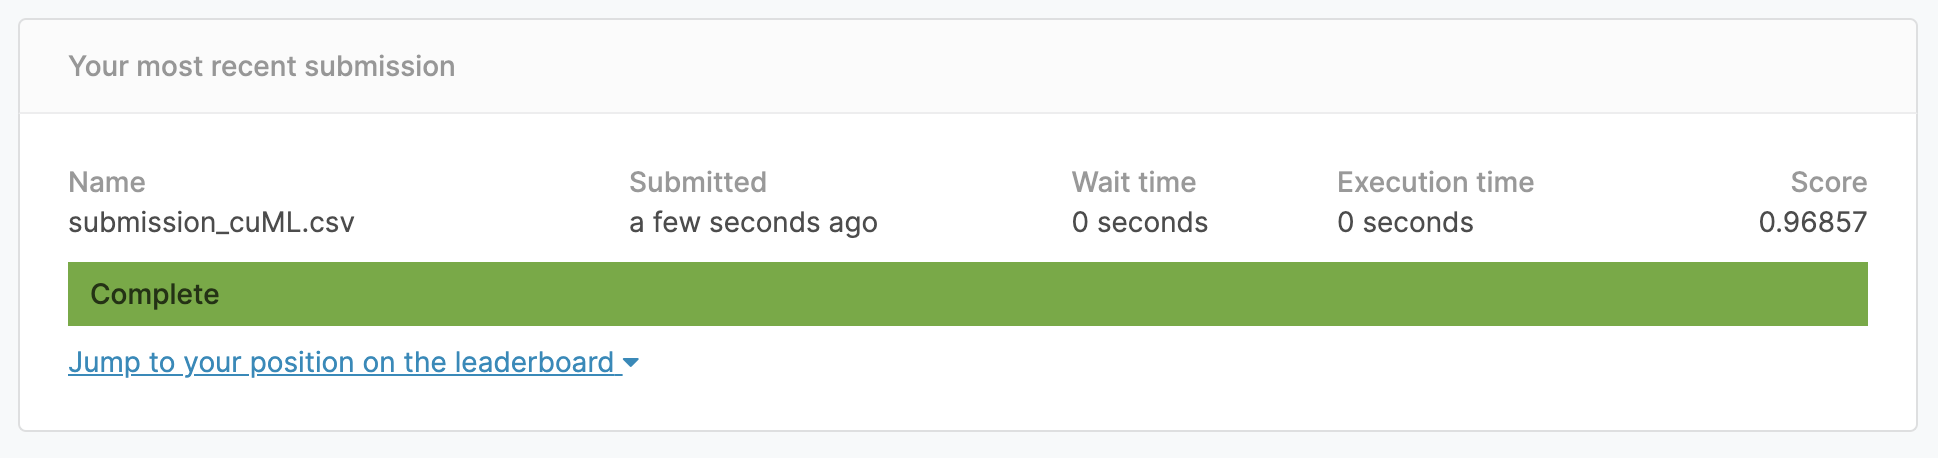

# RESULT with Data Augmentation
In this notebook with data augmentation, we achieve an accuracy of 98.5%. If we create more augmented data and/or create non-linear augmentations, we can achieve accuracy over 99%. Additionally, one can scale columns of the dataset to prioritize certain regions of pixels and increase accuracy further! Or one can ensemble multiple models created with bagging. Because RAPIDS cuML is so fast, we can do kNN plus additional tasks and achieve state of the art accuracies!

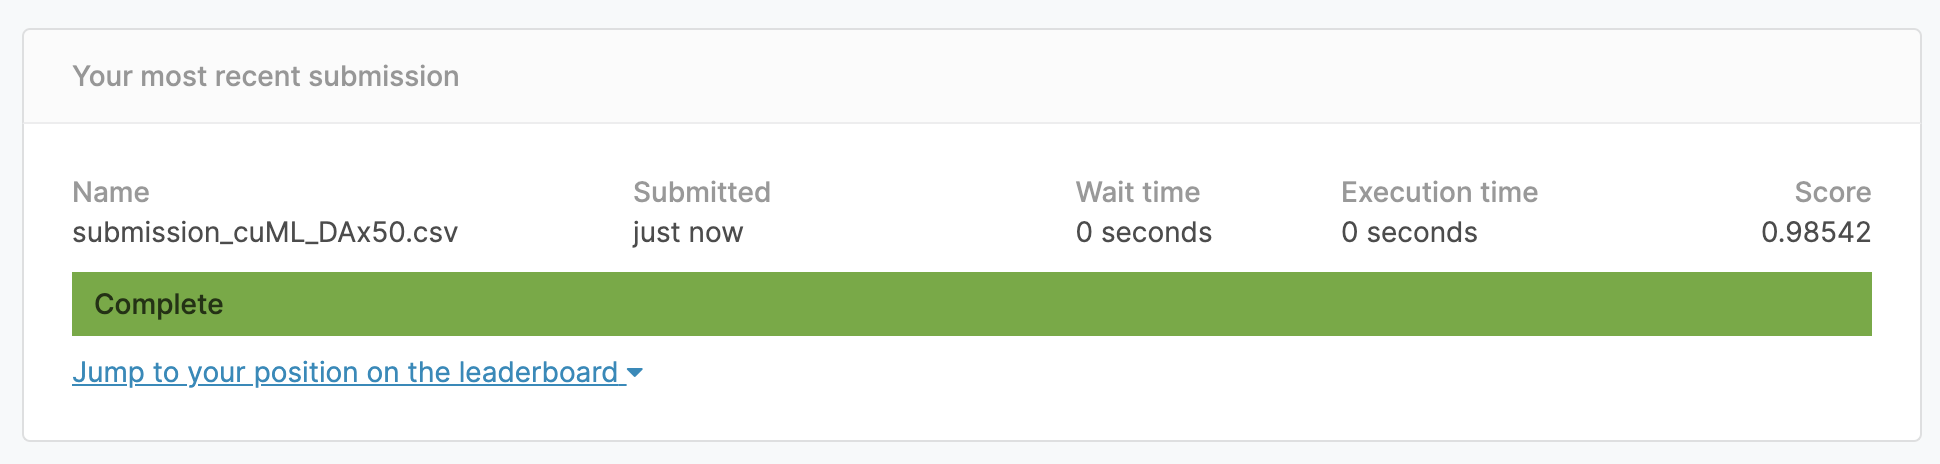